<hr style="height:10px"> 
 
<div class='container2'>
	<div style='padding: 0 7em 2em 0em;'>
	<h1>Trabalho de Inteligência Artificial</h1>
    <h3> <a href="https://github.com/amandakouchi">Amanda Kouchi</a> &#x25CF; <a href="https://github.com/biarog">Beatriz Rogers</a> &#x25CF; <a href="https://github.com/matteoavan">Matteo Savan</a> &#x25CF; <a href="https://github.com/RaulYKomai">Raul Y. Komai</a>
	</div>
</div>


 <hr style="height:5px"> 

    
<h2>Algoritmos e Avaliação em Agrupamento</h2>

## Introdução

Neste *notebook*, será feito o uso de três algoritmos de agrupamento para podermos analisar cada um dos algorítmos e seus usos ideais. O banco de dados utilizado foi providenciado pela nossa Profª Drª Katti Facelli.

Os três algoritmos que faremos uso neste estudo são os seguintes: K-médias, Single-Link e Complete-Link.

---

## Recursos Necessários

Para este *notebook*, deve ser utilizado o `Python 3.6` ou superior com as seguintes bibliotecas externas, que deverão ser instaladas:

* [`matplotlib`](versão 3.9.2 ou superior): construção e exibição de gráficos variados
* [`numpy`](versão 2.1 ou superior): manipulação de dados em formato de vetores e matrizes
* [`pandas`](versão 2.2.2 ou superior): manipulação de dados em formato de tabelas
* [`sklearn`](versão x.x ou superior): completar
* [`seaborn`]versão x.x ou superior): completar

A biblioteca [`os`](https://docs.python.org/3/library/os.html), para realizar tarefas específicas ao Sistema Operacional, também será utilizada. Por fazer parte da [Biblioteca Padrão de Python](https://docs.python.org/pt-br/3/library/), sua instalação não é necessária.

Serão utilizados também os conjuntos de dados disponibilizados junto com este *notebook*, que se encontram no diretório `datasets`, em formato de arquivo `.txt`.

In [125]:
## Imports
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import cluster 
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import seaborn as sns
import sys

%matplotlib inline

DATASETS_DIR = 'datasets'

In [126]:
## Função auxiliar
def load_dataset(dataset_name):
    dataset = pd.read_csv(os.path.join(DATASETS_DIR, dataset_name+'.txt'), sep='\t', index_col = 0)
    return dataset

---
## K-médias

Adicionar descrição do processo de kmédias

In [127]:
## Entrada de dados
maxiter = 100000
k = 10
nome_arquivo = 'monkey'

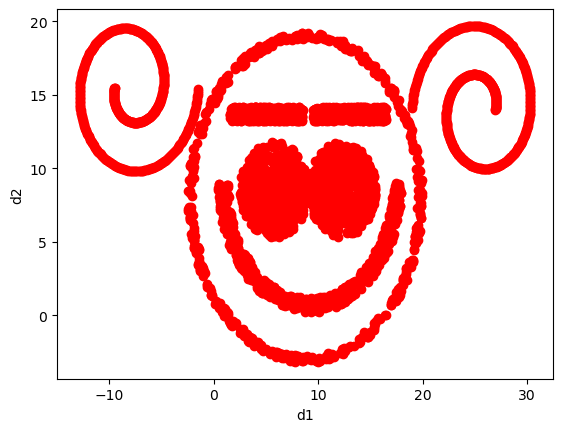

In [128]:
## Plot dos dados de entrada
dados = load_dataset(nome_arquivo)
X = dados[['d1', 'd2']]
plt.scatter(X["d1"],X["d2"], c="red")
plt.xlabel("d1")
plt.ylabel("d2")
plt.show()

In [129]:
## Execução do k-médias
kmedias_ = KMeans(n_clusters=k, max_iter = maxiter)
kmedias = kmedias_.fit_predict(dados[['d1', 'd2']])
print(len(kmedias), kmedias)

4000 [0 6 6 ... 6 6 6]


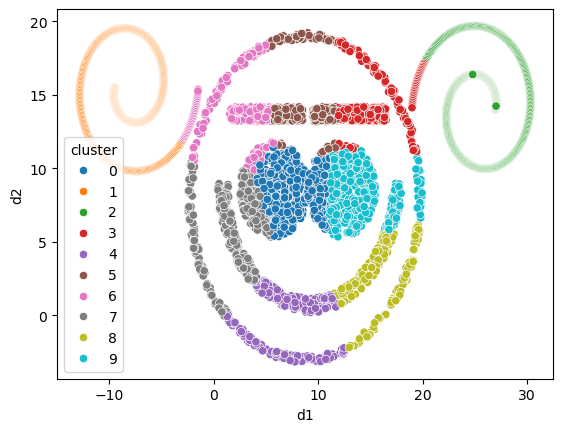

In [130]:
## Plotar após k-médias
df = pd.DataFrame(dados)
df.columns = ["d1","d2"]
df["cluster"] = kmedias
cores = sns.color_palette()[0:k]
df = df.sort_values("sample_label")
sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["cluster"], palette=cores)
plt.show()

In [131]:
## Exportar arquivo
select_ = ['sample_label', 'cluster']
select = [x for x in df.columns if x in select_]
export = df[select]
export.to_csv(nome_arquivo + '_k-media'  + '.csv')

---
## Single-Link

---
## Complete-Link

In [132]:
## Entrada de dados
numero_clusters = 5
nome_arquivo = 'teste'

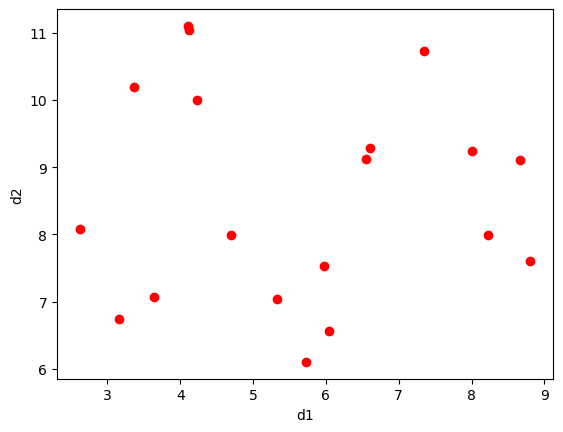

In [133]:
## Plot dos dados de entrada
dados = load_dataset(nome_arquivo)
X = dados[['d1', 'd2']]
plt.scatter(X["d1"],X["d2"], c="red")
plt.xlabel("d1")
plt.ylabel("d2")
plt.show()

In [134]:
## Cálculo Matriz de Distância
matrix_despacial = distance_matrix(x=dados.values, y=dados.values)
matrix_base = np.full((len(matrix_despacial), len(matrix_despacial[0])), 1)

print(len(dados))
complete = [-1]*len(dados)
print(complete)

19
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [135]:
## Função de Complete Link
def complete_link(m_distancias:np):
    clusters:np
    return clusters
        

In [136]:
## Execução do Complete Link
print(len(matrix_despacial) )
for iter in range(len(matrix_despacial) - 10):
    min:int = sys.maxsize
    line:int = 0
    column:int = 0
    
    cluster:bool = True
    cluster_id:int = -1
    
    
    for idx_x, x in enumerate(matrix_despacial):
        for idx_y, y in enumerate(x):
            if y < min and y > 0:
                min = y
                line = idx_x
                column = idx_y

    
    print("min = ", min)      
    print("linha = ", line)
    print("coluna = ", column)
    print("matrix_despacial[line][column]", matrix_despacial[line][column])

    
    print("complete(l, c) = ", complete[line], complete[column])
    if complete[line] < 0 or complete[column] < 0:
       cluster = False
    
    if cluster:
        print("tem cluster")
        matrix_despacial[column][line] = matrix_despacial[line][column] = cluster_id
        
        for idx_n, n in enumerate(complete):
            if n == complete[column] and idx_n != column:
                complete[idx_n] = -cluster_id - 1
        
        complete[line] = complete[column] = -cluster_id - 1
    else :
        print("n tem cluster")
        matrix_despacial[column][line] = matrix_despacial[line][column] = -iter - 1
        complete[line] = complete[column] = iter
     
    print("matrix_despacial[line][column]", matrix_despacial[line][column])
    print("complete(linha) = ", complete[line])
    print("complete(coluna) = ", complete[column])
    
    #print(matrix_despacial[line][column], matrix_despacial[column][line])
    #print(matrix_despacial[line])
    #print(matrix_despacial[column])

    for idx_x, x in enumerate(matrix_despacial[line]):
        if matrix_despacial[line][idx_x] >= matrix_despacial[column][idx_x] and matrix_despacial[column][idx_x]:
            matrix_despacial[column][idx_x] = matrix_despacial[idx_x][column] = x
        else :
            matrix_despacial[line][idx_x] = matrix_despacial[idx_x][line] = matrix_despacial[idx_x][column]

    #print(matrix_despacial[line])
    #print(matrix_despacial[column])


for idx_n, n in enumerate(complete):
    if n == -1:
        complete[idx_n] = max(complete) + 1

print(complete)

19
min =  0.06372235220077974
linha =  1
coluna =  2
matrix_despacial[line][column] 0.06372235220077974
complete(l, c) =  -1 -1
n tem cluster
matrix_despacial[line][column] -1.0
complete(linha) =  0
complete(coluna) =  0
min =  0.1750646188040289
linha =  12
coluna =  14
matrix_despacial[line][column] 0.1750646188040289
complete(l, c) =  -1 -1
n tem cluster
matrix_despacial[line][column] -2.0
complete(linha) =  1
complete(coluna) =  1
min =  0.5629427649805965
linha =  6
coluna =  7
matrix_despacial[line][column] 0.5629427649805965
complete(l, c) =  -1 -1
n tem cluster
matrix_despacial[line][column] -3.0
complete(linha) =  2
complete(coluna) =  2
min =  0.5835312937049737
linha =  3
coluna =  16
matrix_despacial[line][column] 0.5835312937049737
complete(l, c) =  -1 -1
n tem cluster
matrix_despacial[line][column] -4.0
complete(linha) =  3
complete(coluna) =  3
min =  0.6647036815882688
linha =  8
coluna =  9
matrix_despacial[line][column] 0.6647036815882688
complete(l, c) =  -1 -1
n tem

In [137]:
complete = complete_link(matrix_despacial)

UnboundLocalError: cannot access local variable 'clusters' where it is not associated with a value

C:\Users\beatr\AppData\Local\Temp\ipykernel_21444\353550336.py:7: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["cluster"], palette=cores)


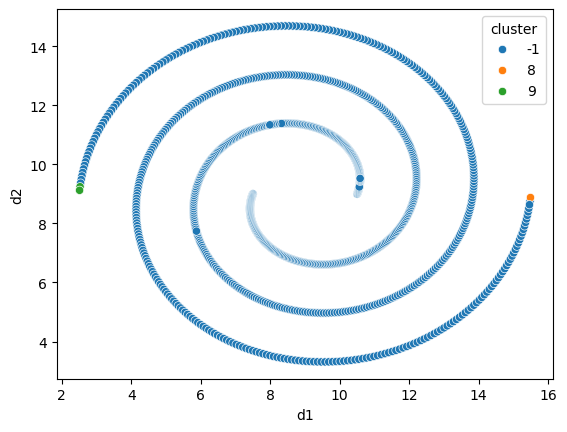

In [159]:
## Plotar após Complete Link
df = pd.DataFrame(dados)
df.columns = ["d1","d2"]
df["cluster"] = complete
cores = sns.color_palette()[0:numero_clusters]
df = df.sort_values("sample_label")
sns.scatterplot(data = df, x=df["d1"], y=df["d2"], hue=df["cluster"], palette=cores)
plt.show()

---
## S-rand

---
## Conclusão